In [1]:
import json
import os
import random
import pandas as pd
import re
import torch
import torchtext.data

from sklearn.model_selection import train_test_split
from torchtext.data import Field, TabularDataset, BucketIterator
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords

In [3]:
# "output.csv"는 raw data

#df = pd.read_csv("output.csv")
#df

## 데이터 전처리

In [ ]:
# 찾은 규칙 기반 전처리

def preprocess(input_string) :
    cleaned1 = re.sub(r'\w+-|그~|어~', '', input_string)

    cleaned2 = re.sub(r'(~|#)(?=\S)|(?<=\S)(~|#)', '', cleaned1)

    cleaned3 = re.sub(r'&+\w+&|@+\w+&|\@\w+', '<고유명사>', cleaned2)

    cleaned4 = re.sub(r'\S*\(\(\w*\)\)\S*', '', cleaned3)

    # Excluding <unk>
    special = re.compile(r'([^가-힣\s\d.,?,<알수없음>])') 
    
    cleaned5 = special.sub('', cleaned4)
    
    cleaned_text_final = re.sub(r'(?<=[\w])([.,?])', r' \1', cleaned5)
    
    return cleaned_text_final

In [ ]:
# 전처리한 문자열 데이터

proc = pd.DataFrame()
proc['standard'] = df['standard'].apply(preprocess)
proc['dialects'] = df['dialects'].apply(preprocess)
proc

In [ ]:
proc.to_csv("preprocess_text.csv")

In [3]:
df = pd.read_csv('preprocess_text.csv')

In [4]:
# 랜덤씨드 설정 후 train, test 데이터 스플릿

train, test = train_test_split(df, test_size=0.2, random_state=777)

In [5]:
test

,Unnamed: 0,standard,dialects
8894,8894,키 아직 조금은 커 아니면 아예 멈췄어,키 아직 쪼끔은 커 아니면 아예 멈췄어
20322,20322,진짜 스트레스 받더라구 그게 그래서 나 아직까지 롭스 안 가거든 그 때 그게 너무 ...,진짜 스트레스 받더라구 그게 그래서 나 아직까지 롭스 안 가거든 그 때 그게 너무 ...
5807,5807,그래 가지고,그래 가주고
60964,60964,아니면 성형 이런 식으로 그런 게 조금,아니면 성형 이런 식으로 그런 게 쫌
43185,43185,조금 그렇고,쫌 그렇고
...,...,...,...
51539,51539,조금 숨이 막히기도 하고 조금 어떻게 반응을 해야 될지 모르겠고 조금 그런 게 있지...,쫌 숨이 막히기도 하고 쫌 어떻게 반응을 해야 될지 모르겠고 쫌 그런 게 있지 그래...
28109,28109,깔라만시라고 레몬 같은 거 원액 같은 게 조금 유행이잖아 .,깔라만시라고 레몬 같은 거 원액 같은 게 쫌 유행이잖아 .
114,114,쉬다가 실패를 했는데 고기가 너무 두꺼워가지고 굽어서,쉬다가 실패를 했는데 고기가 너무 뚜끄버가지고 꿉어서
26942,26942,자유로 하는 거 신청했는데 그게 된 거야 그래가지구 친구랑,자유로 했는 거 신청했는데 그게 된 거야 그래가지구 친구랑


In [6]:
# 스플릿 데이터 저장

train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [7]:
# 토크나이저 Kiwi 패키지 사용

kiwi = Kiwi()
kiwi.add_user_word('<고유명사>', 'NNP', 0) # <고유명사> 라는 인덱스 생성

True

In [8]:
# 형태소 토크나이징

def tokenize(text):
    tokens = kiwi.tokenize(text)
    morphs = [token.split('form=')[1].split(',')[0].strip("'") for token in str(tokens).split('Token')[1:]]
    return morphs

In [9]:
# 어절 토크나이징

tokenize2 = lambda x : x.split() 

In [11]:
# a안: input 어절 토큰 - output 어절 토큰

SRC = Field(sequential=True, use_vocab=True, tokenize=tokenize2, init_token="<sos>", eos_token="<eos>", batch_first=True)
TRG = Field(sequential=True, use_vocab=True, tokenize=tokenize2, init_token="<sos>", eos_token="<eos>", batch_first=True)

In [10]:
# b안: input 형태소 토큰 - output 어절 토큰

SRC = Field(sequential=True, use_vocab=True, tokenize=tokenize, init_token="<sos>", eos_token="<eos>", batch_first=True)
TRG = Field(sequential=True, use_vocab=True, tokenize=tokenize2, init_token="<sos>", eos_token="<eos>", batch_first=True)

In [12]:
# Fields 클래스로 데이터 처리

fields = {'standard':('src', SRC), 'dialects':('trg', TRG)}

In [13]:
train_data, test_data = TabularDataset.splits(path='./', 
                                              train='train.csv',
                                              test='test.csv',
                                              format='csv',
                                              fields=fields)

In [14]:
# torch field 클래스로 잘 들어갔는지 확인

type(train_data.examples[0])

torchtext.data.example.Example

In [15]:
# (1)안 min_freq = 1 : 한 개라도 있는 단어 모두 포함(너무 희귀한 고유명사 제거하기 위함)

SRC.build_vocab(train_data, max_size=40000, min_freq=1)
TRG.build_vocab(train_data, max_size=40000, min_freq=1)

In [16]:
# (1)안 min_freq = 2 : 두 번 이상 등장한 단어들만 취급

SRC.build_vocab(train_data, max_size=40000, min_freq=2)
TRG.build_vocab(train_data, max_size=40000, min_freq=2)

In [17]:
print(len(SRC.vocab))
print(len(TRG.vocab))

28518
29557


In [18]:
# 128 크기의 미니배치 설정

batch_size = 128
train_iterator, test_iterator = BucketIterator.splits((train_data, test_data),
                                                      batch_size=batch_size,
                                                      sort_key=lambda x: len(x.src),
                                                      sort=True)
# 길이 기준 정렬 이유 : 길이가 비슷한 문자열끼리 묶어야 패딩 수를 줄일 수 있음

for i, batch in enumerate(train_iterator):
    print(i,batch)

0 
[torchtext.data.batch.Batch of size 128]
	[.src]:[torch.LongTensor of size 128x3]
	[.trg]:[torch.LongTensor of size 128x4]
1 
[torchtext.data.batch.Batch of size 128]
	[.src]:[torch.LongTensor of size 128x3]
	[.trg]:[torch.LongTensor of size 128x4]
2 
[torchtext.data.batch.Batch of size 128]
	[.src]:[torch.LongTensor of size 128x4]
	[.trg]:[torch.LongTensor of size 128x4]
3 
[torchtext.data.batch.Batch of size 128]
	[.src]:[torch.LongTensor of size 128x4]
	[.trg]:[torch.LongTensor of size 128x4]
4 
[torchtext.data.batch.Batch of size 128]
	[.src]:[torch.LongTensor of size 128x4]
	[.trg]:[torch.LongTensor of size 128x6]
5 
[torchtext.data.batch.Batch of size 128]
	[.src]:[torch.LongTensor of size 128x4]
	[.trg]:[torch.LongTensor of size 128x10]
6 
[torchtext.data.batch.Batch of size 128]
	[.src]:[torch.LongTensor of size 128x4]
	[.trg]:[torch.LongTensor of size 128x4]
7 
[torchtext.data.batch.Batch of size 128]
	[.src]:[torch.LongTensor of size 128x4]
	[.trg]:[torch.LongTensor of siz

In [19]:
# 미니배치 인덱스 출력

for i, batch in enumerate(train_iterator):
    print(i,batch)
    print(batch.src.shape)
    print(batch.src)
    str= ''
    
    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for k in range(batch.src.shape[0]):
        str=''
        for j in range(batch.src.shape[1]):
            str += ' ' + SRC.vocab.itos[batch.src[k][j].item()]
        print(str)
        
    break

0 
[torchtext.data.batch.Batch of size 128]
	[.src]:[torch.LongTensor of size 128x3]
	[.trg]:[torch.LongTensor of size 128x4]
torch.Size([128, 3])
tensor([[    2,    14,     3],
        [    2,    45,     3],
        [    2,     4,     3],
        [    2,    70,     3],
        [    2,    16,     3],
        [    2,    54,     3],
        [    2,    17,     3],
        [    2,    99,     3],
        [    2, 10344,     3],
        [    2,   130,     3],
        [    2,    14,     3],
        [    2, 20652,     3],
        [    2,  7166,     3],
        [    2,    14,     3],
        [    2,    14,     3],
        [    2,    17,     3],
        [    2,    14,     3],
        [    2,    99,     3],
        [    2,  6634,     3],
        [    2,    14,     3],
        [    2,    54,     3],
        [    2,   547,     3],
        [    2,   470,     3],
        [    2,  8529,     3],
        [    2,   130,     3],
        [    2,    14,     3],
        [    2,     4,     3],
        [    2, 

## 모델 정의

In [20]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim # 임베딩 차원
        self.n_heads = n_heads # 헤드(head)의 개수: 서로 다른 어텐션(attention) 컨셉의 수
        self.head_dim = hidden_dim // n_heads # 각 헤드(head)에서의 임베딩 차원

        self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query 값에 적용될 FC 레이어
        self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key 값에 적용될 FC 레이어
        self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value 값에 적용될 FC 레이어

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        # query: [batch_size, query_len, hidden_dim]
        # key: [batch_size, key_len, hidden_dim]
        # value: [batch_size, value_len, hidden_dim]
 
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q: [batch_size, query_len, hidden_dim]
        # K: [batch_size, key_len, hidden_dim]
        # V: [batch_size, value_len, hidden_dim]

        # hidden_dim → n_heads X head_dim 형태로 변형
        # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q: [batch_size, n_heads, query_len, head_dim]
        # K: [batch_size, n_heads, key_len, head_dim]
        # V: [batch_size, n_heads, value_len, head_dim]

        # Attention Energy 계산
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy: [batch_size, n_heads, query_len, key_len]

        # 마스크(mask)를 사용하는 경우
        if mask is not None:
            # 마스크(mask) 값이 0인 부분을 -1e10으로 채우기
            energy = energy.masked_fill(mask==0, -1e10)

        # 어텐션(attention) 스코어 계산: 각 단어에 대한 확률 값
        attention = torch.softmax(energy, dim=-1)

        # attention: [batch_size, n_heads, query_len, key_len]

        # 여기에서 Scaled Dot-Product Attention을 계산
        x = torch.matmul(self.dropout(attention), V)

        # x: [batch_size, n_heads, query_len, head_dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        # x: [batch_size, query_len, n_heads, head_dim]

        x = x.view(batch_size, -1, self.hidden_dim)

        # x: [batch_size, query_len, hidden_dim]

        x = self.fc_o(x)

        # x: [batch_size, query_len, hidden_dim]

        return x, attention

In [21]:
# 포워드 레이어 (선형변환)

class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, hidden_dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        # x: [batch_size, seq_len, pf_dim]

        x = self.fc_2(x)

        # x: [batch_size, seq_len, hidden_dim]

        return x

In [22]:
# 인코더 레이어

class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 하나의 임베딩이 복제되어 Query, Key, Value로 입력되는 방식
    def forward(self, src, src_mask):

        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        # self attention
        # 필요한 경우 마스크(mask) 행렬을 이용하여 어텐션(attention)할 단어를 조절 가능
        _src, _ = self.self_attention(src, src, src, src_mask)

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        return src

In [23]:
# 인코더 모델 생성

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, src_len]

        # 소스 문장의 임베딩과 위치 임베딩을 더한 것을 사용
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src: [batch_size, src_len, hidden_dim]

        # 모든 인코더 레이어를 차례대로 거치면서 순전파(forward) 수행
        for layer in self.layers:
            src = layer(src, src_mask)

        # src: [batch_size, src_len, hidden_dim]

        return src # 마지막 레이어의 출력을 반환

In [24]:
# 디코더 레이어

class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 인코더의 출력 값(enc_src)을 어텐션(attention)하는 구조
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        # self attention
        # 자기 자신에 대하여 어텐션(attention)
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # encoder attention
        # 디코더의 쿼리(Query)를 이용해 인코더를 어텐션(attention)
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention

In [25]:
# 디코더 모델 생성

class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, trg_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)

        # output: [batch_size, trg_len, output_dim]

        return output, attention

In [26]:
# 트랜스포머 모델

class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    # 소스 문장의 <pad> 토큰에 대하여 마스크(mask) 값을 0으로 설정
    def make_src_mask(self, src):

        # src: [batch_size, src_len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    def make_trg_mask(self, trg):

        # trg: [batch_size, trg_len]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        """
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        # trg_sub_mask: [trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask: [batch_size, 1, trg_len, trg_len]

        return trg_mask

    def forward(self, src, trg):

        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask: [batch_size, 1, 1, src_len]
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        enc_src = self.encoder(src, src_mask)

        # enc_src: [batch_size, src_len, hidden_dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return output, attention

In [27]:
# 모델 튜닝

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [28]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [29]:
# 파라미터 개수

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 26,468,213 trainable parameters


In [30]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(28518, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
    

In [31]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [25]:
# 모델 학습(train) 함수

def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # 출력 단어의 마지막 인덱스(<eos>)는 제외
        # 입력을 할 때는 <sos>부터 시작하도록 처리
        output, _ = model(src, trg[:,:-1])

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0(<sos>)은 제외
        trg = trg[:,1:].contiguous().view(-1)

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [27]:
# 모델 평가(evaluate) 함수

def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # 출력 단어의 마지F막 인덱스(<eos>)는 제외
            # 입력을 할 때는 <sos>부터 시작하도록 처리
            output, _ = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0(<sos>)은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

## 모델 트레인 시작

In [26]:
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
import time
import math
import random

N_EPOCHS = 20
CLIP = 1

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')

Epoch: 01 | Time: 10m 43s
	Train Loss: 4.571 | Train PPL: 96.679
Epoch: 02 | Time: 10m 54s
	Train Loss: 2.010 | Train PPL: 7.463
Epoch: 03 | Time: 10m 52s
	Train Loss: 1.221 | Train PPL: 3.390
Epoch: 04 | Time: 10m 57s
	Train Loss: 0.825 | Train PPL: 2.281
Epoch: 05 | Time: 10m 59s
	Train Loss: 0.581 | Train PPL: 1.788
Epoch: 06 | Time: 11m 15s
	Train Loss: 0.442 | Train PPL: 1.556
Epoch: 07 | Time: 11m 14s
	Train Loss: 0.360 | Train PPL: 1.434
Epoch: 08 | Time: 11m 13s
	Train Loss: 0.304 | Train PPL: 1.355
Epoch: 09 | Time: 11m 18s
	Train Loss: 0.266 | Train PPL: 1.305
Epoch: 10 | Time: 11m 19s
	Train Loss: 0.236 | Train PPL: 1.266
Epoch: 11 | Time: 11m 18s
	Train Loss: 0.209 | Train PPL: 1.232
Epoch: 12 | Time: 11m 18s
	Train Loss: 0.187 | Train PPL: 1.206
Epoch: 13 | Time: 11m 29s
	Train Loss: 0.170 | Train PPL: 1.186
Epoch: 14 | Time: 11m 40s
	Train Loss: 0.159 | Train PPL: 1.172
Epoch: 15 | Time: 11m 45s
	Train Loss: 0.149 | Train PPL: 1.160
Epoch: 16 | Time: 11m 57s
	Train Loss: 

In [29]:
# 학습된 모델 저장

#torch.save(model.state_dict(), 'transformer_model.pth')

In [30]:
model.load_state_dict(torch.load('transformer_model_승현.pth'))

test_loss = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

Test Loss: 0.747 | Test PPL: 2.110


In [31]:
# 번역(translation) 함수
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50, logging=True):
    model.eval() # 평가 모드

    max_len = len(sentence) + 1
    if isinstance(sentence, type(str)):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    if logging:
        print(f"전체 소스 토큰: {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    if logging:
        print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_src_mask(src_tensor)

    # 인코더(endocer)에 소스 문장을 넣어 출력 값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # <eos>를 만나는 순간 끝
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:], attention

In [113]:
# 변환된 문장 출력

example_idx = range(0, 16000)

test_df = pd.read_csv("test.csv")
tokens = [sentence.split() for sentence in test_df['dialects']]
references = [[sentence.replace(' ?', '?').replace(' .', '.').replace(' ,', ',')] 
              for sentence in test_df['dialects']][0:16000]
predictions = []

for example_ind in example_idx:
  src = vars(test_data.examples[example_ind])['src']
  trg = vars(test_data.examples[example_ind])['trg']

# print(f'소스 문장: {src}')
# print(f'타겟 문장: {trg}')

  translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)
  output = []
  for i, tok in enumerate(translation) :
        if tok == '<unk>' :
            output.append(tokens[example_ind][min(i,len(tokens[example_ind])-1)])
        else:
            output.append(translation[i])
  output_sentence = ' '.join(output).replace(' ?', '?').replace(' .', '.').replace(' ,', ',')
  predictions.append(output_sentence)


  print("모델 출력 결과:", " ".join(output), "\n")

소스 문장: ['사람이', '너도', '배울', '만큼', '남들처럼', '똑같이', '공부하고', '했는데']
타겟 문장: ['사람이', '니도', '배울', '만큼', '남들처럼', '똑같이', '공부하고', '했는데']
전체 소스 토큰: ['<sos>', '사람이', '너도', '배울', '만큼', '남들처럼', '똑같이', '공부하고', '했는데', '<eos>']
소스 문장 인덱스: [2, 108, 130, 3829, 1160, 0, 941, 2679, 103, 3]

 문장: 사람이 너도 배울 만큼 남들처럼 똑같이 공부하고 했는데
모델 출력 결과: 사람이니도 애만큼 <unk> 똑같이 좋을 했는데 했는데


## 모델 성능 평가

In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu

bleu_score = corpus_bleu(references, predictions)
print(f'Average Bleu Score: {bleu_score}')

In [ ]:
# min-freq 1: 어절 - 어절 - 0.7643
# min-freq 1: 형태소 - 어절 - 0.6376 
# min-freq 2: 어절 - 어절 - 0.7638
# min-freq 2: 형태소 - 어절 - 0.6268
# min-freq 2: 어절 - 어절(, . 붙어있는 ver) - 0.7637

## 인퍼런스

In [ ]:
import spacy
from spacy.lang.ko.examples import sentences 
import de_core_news_sm

# 새로운 입력 문장
new_input = "쿠빅이가 오이를 잘 먹지 않니?"

# 번역 함수를 사용하여 번역 수행
translation, attention, tokens = translate_sentence(new_input, SRC, TRG, model, device, logging=True)

# 번역 결과 출력
output = []

for i, tok in enumerate(translation):
    if tok == '<unk>':
        output.append(tokens[i+1])
    else:
        output.append(tok)

# output 리스트를 문자열로 변환하여 출력
output_sentence = ' '.join(output).replace(' ?', '?').replace(' .', '.').replace(' ,', ',')
print("번역 결과:", output_sentence)

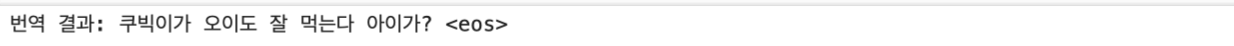

In [ ]:
def translate_sentences(sentences, src_field, trg_field, model, device, max_len=50, logging=True):
    translations = []
    for sentence in sentences:
        translation, attention, tokens = translate_sentence(sentence, src_field, trg_field, model, device, max_len, logging)
        translations.append(translation)
    return translations

# New input sentences as a list
new_inputs = [
    "너 그거 봤어?",
    "말도 못 합니다 예",
    "안 그래?",
    "나 그거 해보려고.",
    "너 오늘 조금 예쁘다"
]

# Perform translation for the list of input sentences
translations = translate_sentences(new_inputs, SRC, TRG, model, device, logging=True)

# Print the translations
for input_sentence, translation in zip(new_inputs, translations):
    output = []
    for i, tok in enumerate(translation):
        if tok == '<unk>':
            output.append(tokens[i+1])
        else:
            output.append(tok)
    output_sentence = ' '.join(output).replace(' ?', '?').replace(' .', '.').replace(' ,', ',')
    print(f"Input Sentence: {input_sentence}")
    print(f"Translation: {output_sentence}\n")

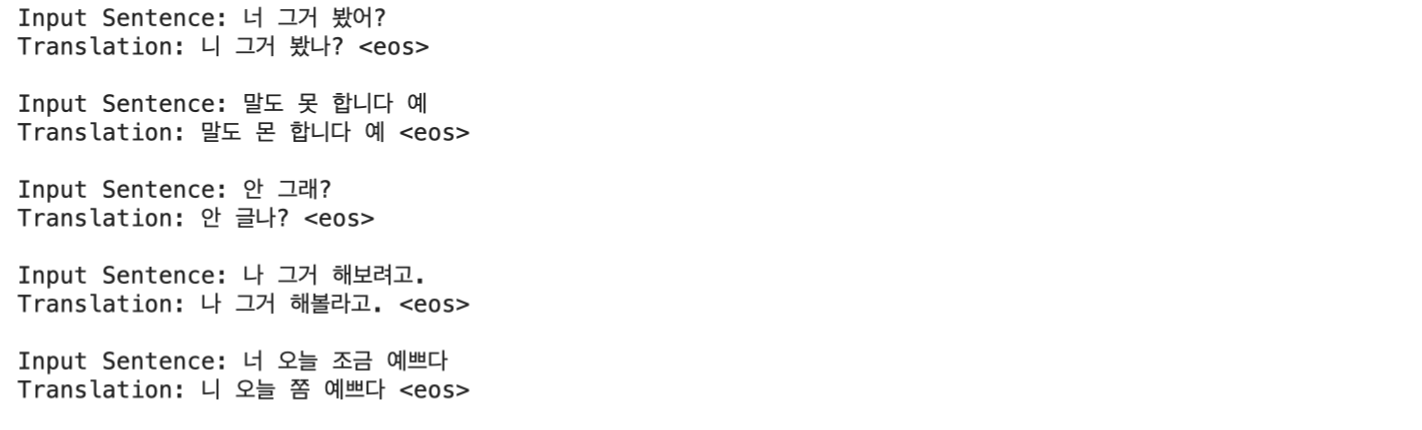